In [4]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import glob
import skimage
from keras import layers
from patchify import patchify, unpatchify
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFilter
from tensorflow.keras.layers import InputLayer
from keras.mixed_precision import Policy

In [5]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Load the model you trained in task5_training.ipynb
patch_size=256
example_file_name = "/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task5/01_task5/rayanedaborisova_220471_unet_model_256px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1}, compile=False)

ValueError: Unrecognized keyword arguments: ['batch_shape']

In [ ]:
# Define any functions you need to process the mask e.g. Task 2
def cropped(image):
    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(image, 65, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assuming it is the petri dish)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Determine the size of the square
    side_length = max(w, h)

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the coordinates for the square crop
    new_x = max(0, center_x - side_length // 2)
    new_y = max(0, center_y - side_length // 2)
    new_x_end = min(image.shape[1], center_x + side_length // 2)
    new_y_end = min(image.shape[0], center_y + side_length // 2)

    # Crop the image to the square
    cropped_image = image[new_y:new_y_end, new_x:new_x_end]

    

    return cropped_image, (new_x, new_y, side_length, side_length)

In [ ]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


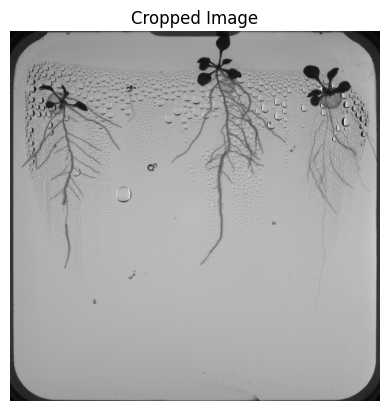

(2746, 2746)

In [ ]:
# Find the petri dish
petri_dish, size = cropped(image)
# Display the cropped image
plt.imshow(cv2.cvtColor(petri_dish, cv2.COLOR_BGR2RGB))
plt.title("Cropped Image")
plt.axis("off")
plt.show()
petri_dish.shape

In [ ]:
# Find the petri dish
petri_dish.shape

(2746, 2746)

In [ ]:
# Define the function to predict the mask
def padding(image, patch_size):
    # Get the height and width of the image
    h = image.shape[0]
    w = image.shape[1]
    # Calculate the amount of padding needed for both height and width
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    # Calculate the padding amounts for the top, bottom, left, and right sides
    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding
    # Calculate the padding amounts for the left and right sides
    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
    # Apply the padding to the image
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

(2816, 2816)

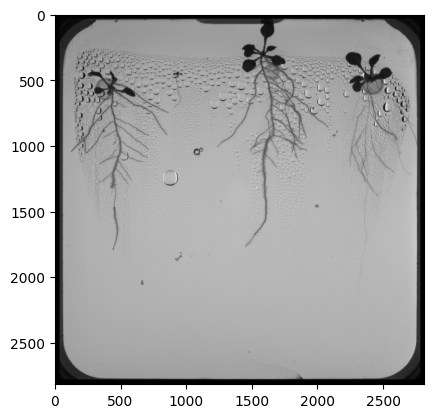

In [ ]:
# Pad the petru dish
petri_dish_padded = padding(petri_dish, 256)
plt.imshow(petri_dish_padded, cmap='gray')
petri_dish_padded.shape

Text(0.5, 1.0, 'Prediction')

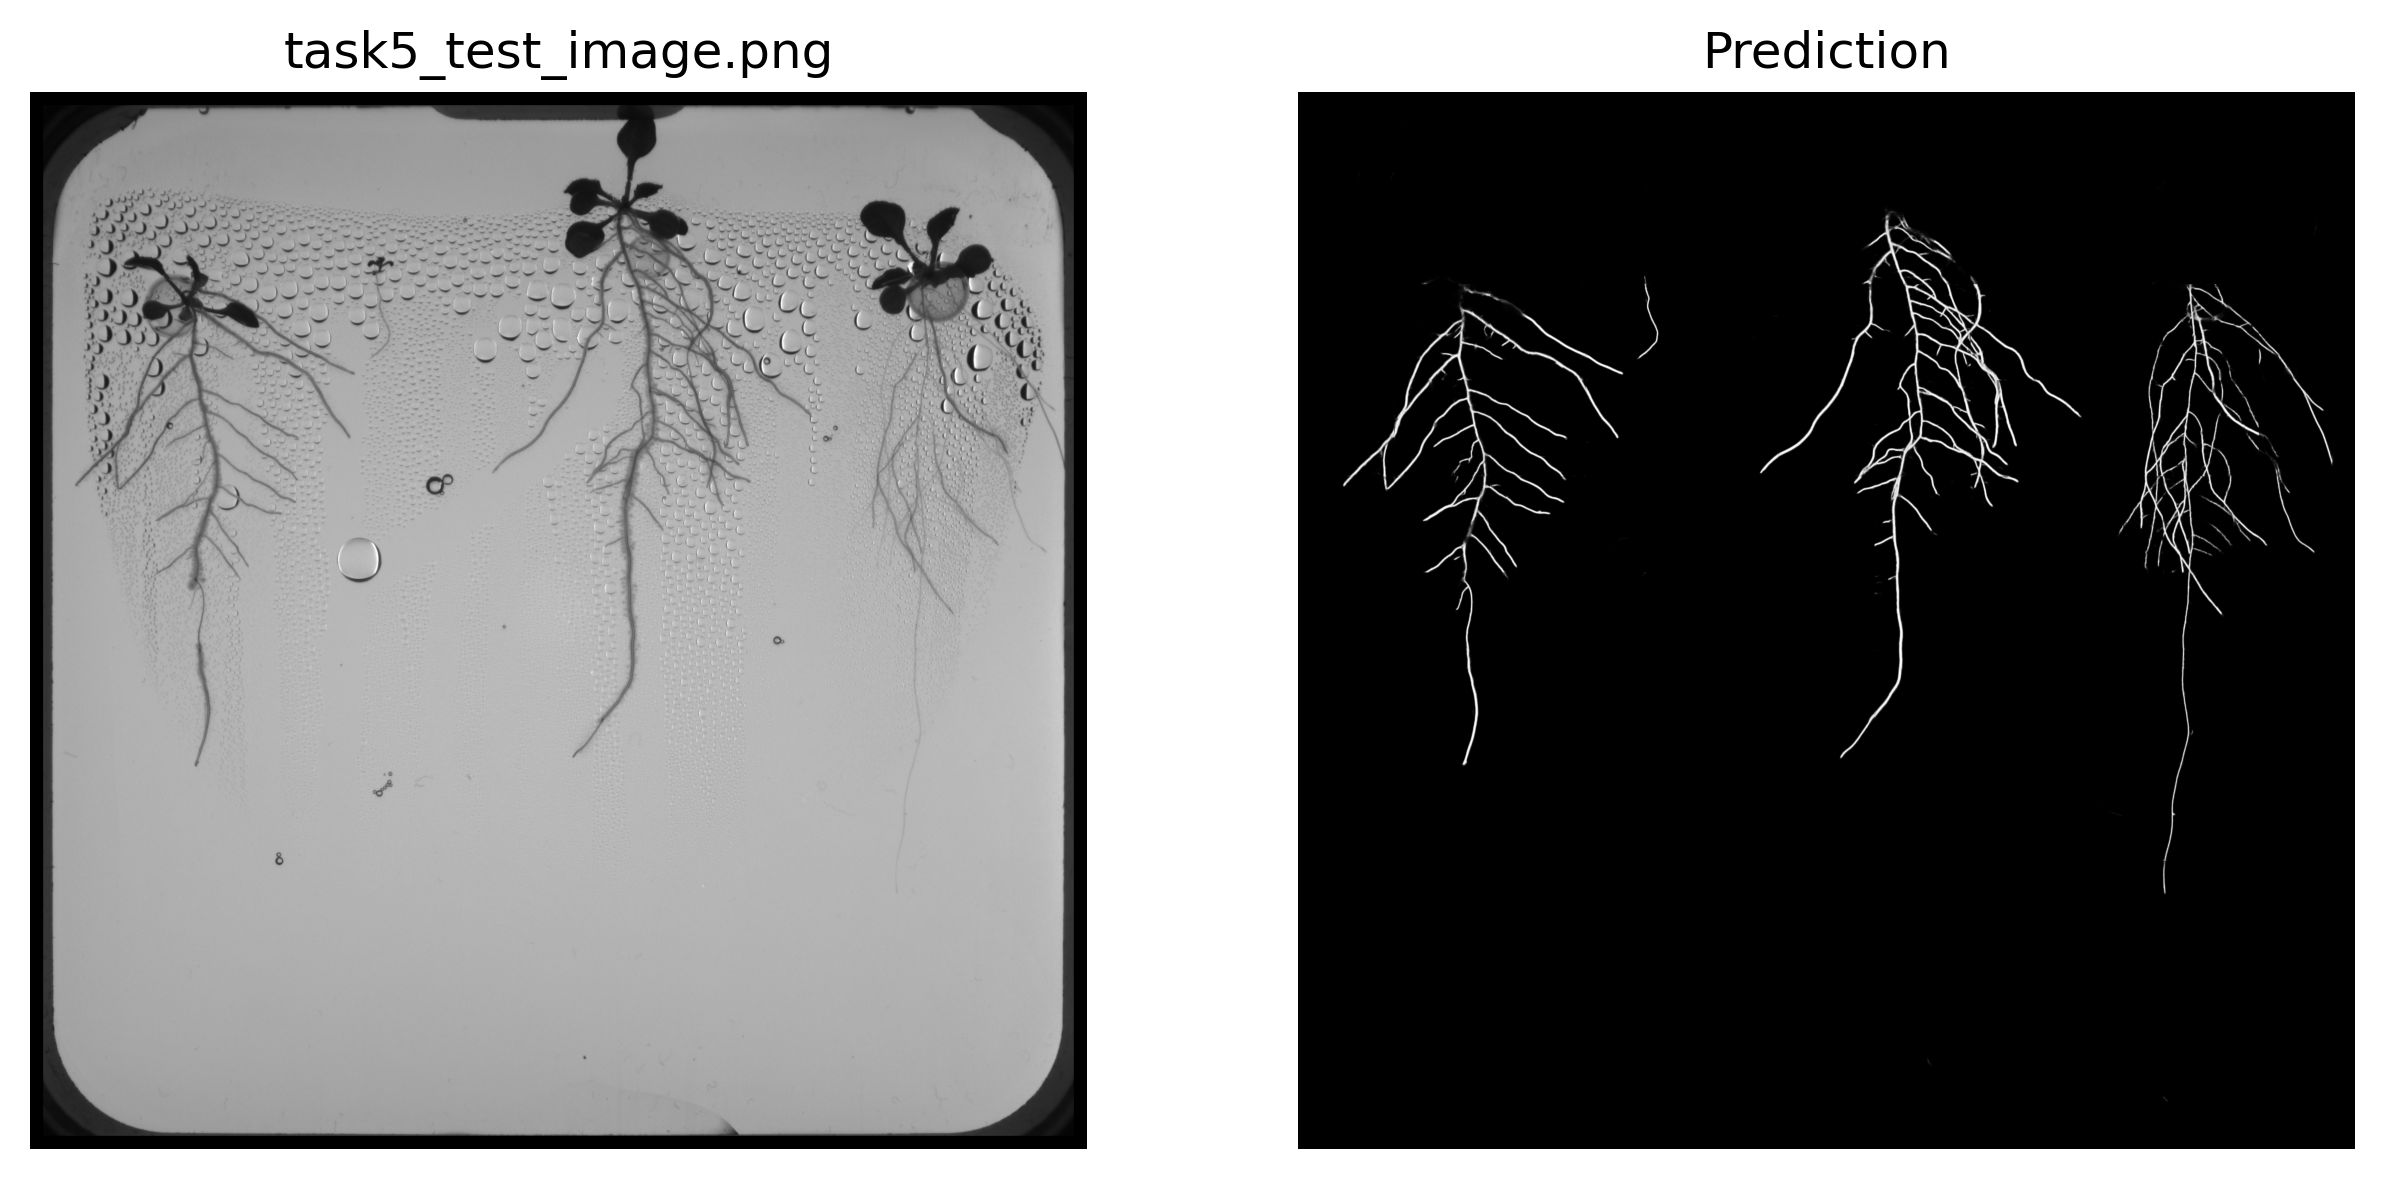

In [ ]:
# Define the function to predict the mask
def predict(petri_dish_padded, patch_size):
    # PATCH
    patches = patchify(petri_dish_padded, (patch_size, patch_size), step=patch_size)
    # PREDICT
    preds_all = []
    for el in patches:
        preds = model(el/255.0)
        preds_all.append(preds)
    preds_all = np.array(preds_all)
    # UNPATCH
    predicted_mask = unpatchify(preds_all[:,:,:,:,0], (petri_dish_padded.shape[0], petri_dish_padded.shape[1]))

    return predicted_mask
# Predict the mask
predicted_mask = predict(petri_dish_padded, patch_size)
# Display the predicted mask
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [ ]:
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

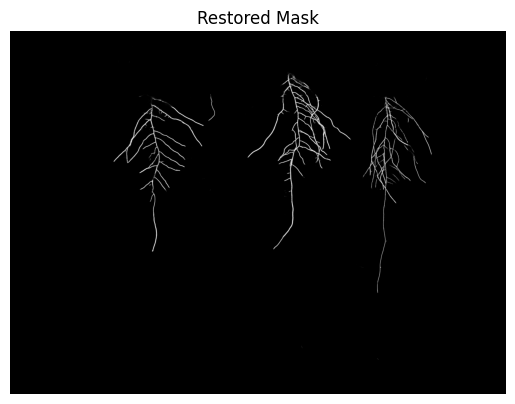

In [ ]:
# Define the function to resize and position the mask
def adjust_and_fit_mask(predicted_mask, size, original_shape, cropped_image):
    # Extract crop info
    x_new, y_new, side_length, side_length = size

    # Scale the mask values if necessary
    if predicted_mask.max() <= 1.0:
        predicted_mask = (predicted_mask * 255).astype(np.uint8)

    # Create a blank canvas matching the original image size
    restored_mask = np.zeros((original_shape[0], original_shape[1]), dtype=np.uint8)

    # Calculate padding for height and width
    height_diff = petri_dish_padded.shape[0] - cropped_image.shape[0]
    width_diff = petri_dish_padded.shape[1] - cropped_image.shape[1]

    top_padding = height_diff // 2
    bottom_padding = height_diff - top_padding  # Remaining goes to bottom
    left_padding = width_diff // 2
    right_padding = width_diff - left_padding  # Remaining goes to right

    # Adjust x_new and y_new
    y_new = int(y_new - top_padding)
    x_new = int(x_new - left_padding)

    # Ensure indices stay within bounds
    y_new = max(0, y_new)
    x_new = max(0, x_new)

    # Place the predicted mask into the correct position on the canvas
    restored_mask[y_new:y_new + predicted_mask.shape[0], x_new:x_new + predicted_mask.shape[1]] = predicted_mask

    return restored_mask
# Define the original image shape
original_shape = image.shape[:2]  # Height and width of the original image

# Restore the mask to the original size and position
predicted_mask_corrected = adjust_and_fit_mask(predicted_mask, size, original_shape, petri_dish)

# Visualize the restored mask
plt.imshow(predicted_mask_corrected, cmap='gray')
plt.axis("off")
plt.title("Restored Mask")
plt.show()

In [ ]:
# Apply the corrections and check whether the mask fits the original image
print(predicted_mask_corrected.shape)
predicted_mask_corrected.shape == image.shape

(3006, 4112)


True

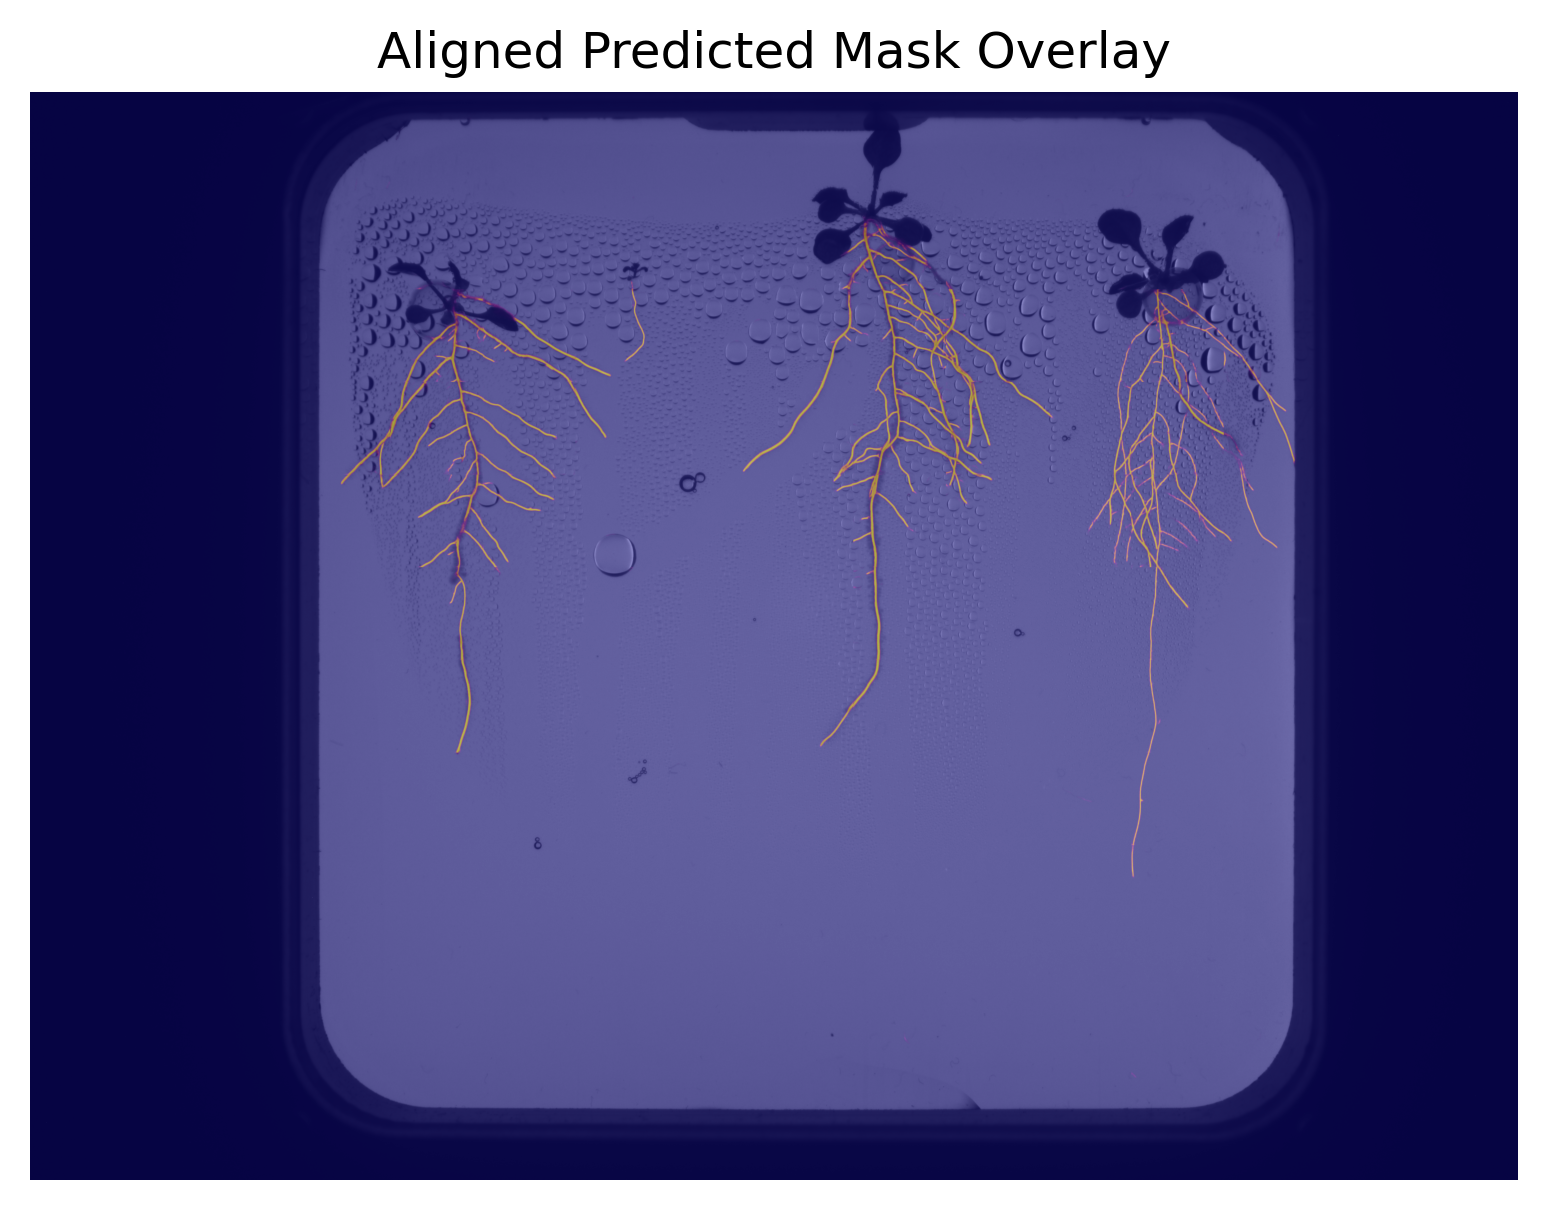

In [ ]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.

plt.figure(dpi=300)
plt.imshow(image, cmap="gray")
plt.imshow(predicted_mask_corrected, cmap="plasma", alpha=0.5)
plt.title("Aligned Predicted Mask Overlay")
plt.axis("off")
plt.show()

In [ ]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected).astype(np.uint8)
assert(predicted_mask_corrected.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_rayanedaborisova_220471.png', mask_image)

True

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.